# Chapter 5. Learning Embeddings with Continuous Bag of Words (CBOW)

## Imports

In [3]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

## Data Vectorization classes

### The Vocabulary

In [6]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, mask_token="<MASK>", add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            mask_token (str): the MASK token to add into the Vocabulary; indicates
                a position that will not be used in updating the model's parameters
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
            
        """

        #   _token_to_idx for vocab:
        #                           {'<MASK>': 0, '<UNK>': 1, 'apple': 2, 'banana': 3, ....., 'zoo': 6137}
        #   _idx_to_token: 
        #                           {0:'<MASK>'0, 1:'<UNK>', 2:'apple',   3:'banana', ......, 6137:'zoo'}
                 
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        self._mask_token = mask_token
        
        self.mask_index = self.add_token(self._mask_token)  # mask_index set to 0
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [7]:
class CBOWVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""    
    def __init__(self, cbow_vocab):
        """
        Args:
            cbow_vocab (Vocabulary): maps words to integers
        """
        self.cbow_vocab = cbow_vocab

    def vectorize(self, context, vector_length=-1):
        """
        Args:
            context (str): the string of words separated by a space
            vector_length (int): an argument for forcing the length of index vector
        """
       
        # e.g., "frankenstein , or the prometheus by mary wolls" -> [3, 5, 9, 3, .., 35]
        indices = [self.cbow_vocab.lookup_token(token) for token in context.split(' ')]
        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)   # vector length is 10.
        out_vector[:len(indices)] = indices     # e.g., "frankenstein , or the prometheus by mary wolls" -> [3, 5, 9, 3, .., 35]
        out_vector[len(indices):] = self.cbow_vocab.mask_index # padding, 
                                                               # [3, 5, 9, 3, .., 35] -> [3, 5, 9, 3, .., 35, 0, 0]
        return out_vector
    
    @classmethod
    def from_dataframe(cls, cbow_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            cbow_df (pandas.DataFrame): the target dataset
        Returns:
            an instance of the CBOWVectorizer
        """
        cbow_vocab = Vocabulary()
        for index, row in cbow_df.iterrows():
            for token in row.context.split(' '):  # word-level token
                cbow_vocab.add_token(token)
            cbow_vocab.add_token(row.target)
            
        return cls(cbow_vocab)

### The Dataset

In [9]:
class CBOWDataset(Dataset):
    def __init__(self, cbow_df, vectorizer):
        """
        Args:
            cbow_df (pandas.DataFrame): the dataset
            vectorizer (CBOWVectorizer): vectorizer instatiated from dataset
        """
        self.cbow_df = cbow_df
        self._vectorizer = vectorizer
        
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, cbow_df.context))  # calculate the max sequence length from the context 
                                                                       # field, which is 10.
        
        self.train_df = self.cbow_df[self.cbow_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.cbow_df[self.cbow_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.cbow_df[self.cbow_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, cbow_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            cbow_csv (str): location of the dataset
        Returns:
            an instance of CBOWDataset
        """
        cbow_df = pd.read_csv(cbow_csv)
        train_cbow_df = cbow_df[cbow_df.split=='train']
        return cls(cbow_df, CBOWVectorizer.from_dataframe(train_cbow_df))

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer
        
    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        context_vector = \
            self._vectorizer.vectorize(row.context, self._max_seq_length)  # create a context vector with _max_seq_length
        target_index = self._vectorizer.cbow_vocab.lookup_token(row.target)

        return {'x_data': context_vector,   # e.g., [3, 5, 9, 3, .., 35, 0, 0]
                'y_target': target_index}   # e.g., 245

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## The Model: CBOW

### torch.nn.Embedding
- A simple lookup table that stores embeddings of a fixed dictionary and size.
This module is often used to store word embeddings and retrieve them using indices. The input to the module is a list of indices, and the output is the corresponding word embeddings.
- With padding_idx set, the embedding vector at padding_idx is initialized to all zeros. The gradient for this vector from Embedding is always zero.

In [12]:
class CBOWClassifier(nn.Module): # Simplified cbow Model
    def __init__(self, vocabulary_size, embedding_size, padding_idx=0):
        """
        Args:
            vocabulary_size (int): number of vocabulary items, controls the
                number of embeddings and prediction vector size
            embedding_size (int): size of the embeddings
            padding_idx (int): default 0; Embedding will not use this index
        """
        super(CBOWClassifier, self).__init__()
        
        self.embedding =  nn.Embedding(num_embeddings=vocabulary_size,   # e.g., (6138, 50)
                                       embedding_dim=embedding_size,
                                       padding_idx=padding_idx)
        self.fc1 = nn.Linear(in_features=embedding_size,           # Applies a linear transformation to the incoming data
                             out_features=vocabulary_size)         # e.g., (batch, 50) -> (batch, 6138) 

        self.dpout = nn.Dropout(p=0.3) # for drop out, p = probability of an element to be zeroed. Default: 0.5
        
    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_embedded =  self.embedding(x_in)  # (batch, input_dim)->(batch, input_dim, embedding_size); (batch,10)->(batch,10,50)
                                            # E.g., [ [2, 4, 5, ..., 0], [5, 8, 25, ..., 0], ... ] 
                                            # ->    [ [[0.5, 0.4, ..., 0.8], [0.3, 0.2, ..., 0.5], [0.4, 0.2, ..., 0.6], ...], 
                                            #         [[0.3, 0.8, ..., 0.2], [0.4, 0.5, ..., 0.2], [0.8, 0.3, ..., 0.9], ...],                                
                                            #      .... ]
        
        x_embedded_sum = x_embedded.sum(dim=1)  #  (batch, input_dim, embedding_size)->(batch, embedding_size)
                                                #  (batch, 10, 50) -> (batch, 50)
        x_embedded_sum = self.dpout(x_embedded_sum)             
        
        y_out = self.fc1(x_embedded_sum)        # (batch, embedding_size)->(batch, out_features); (batch, 50)->(batch, 6138)
        
        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)
            
        return y_out                            # (batch, out_features); (batch, 6138)

## Training Routine

### Helper functions

In [15]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t  # update 'early_stopping_best_val'

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1) # y_pred: (batch, output_dim); y_pred_indices: (batch)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()  # y_target: (batch)
    return n_correct / len(y_pred_indices) * 100

#### general utilities

In [17]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

### Settings and some prep work

In [19]:
args = Namespace(
    # Data and Path information
    cbow_csv="data/books/frankenstein_with_splits.csv",
    model_state_file="model.pth",
    save_dir="model_storage/ch5/cbow",
    # Model hyper parameters
    embedding_size=50,
    # Training hyper parameters
    seed=1337,
    num_epochs=100,
    learning_rate=0.0001,
    batch_size=128,
    early_stopping_criteria=5,
    # Runtime options
    cuda=True,
    catch_keyboard_interrupt=True,
    expand_filepaths_to_save_dir=True
)

if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)   
    print("Expanded filepaths: ")
    print("\t{}".format(args.model_state_file))
    

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/ch5/cbow\model.pth
Using CUDA: False


### Initializations

In [21]:
print("Loading dataset and creating vectorizer")
dataset = CBOWDataset.load_dataset_and_make_vectorizer(args.cbow_csv)
    
vectorizer = dataset.get_vectorizer()

classifier = CBOWClassifier(vocabulary_size=len(vectorizer.cbow_vocab), 
                            embedding_size=args.embedding_size)


Loading dataset and creating vectorizer


### Training loop

In [23]:
classifier = classifier.to(args.device)
    
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=1)
train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

dataset.set_split('val')
val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'])  # (batch, input_dim) -> y_pred: (batch, output_dim)
                                                            
            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target']) # batch_dict['y_target']: (batch,)
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            with torch.no_grad():  # Disable gradient computation
                 y_pred =  classifier(x_in=batch_dict['x_data'])   # y_pred: (batch, output_dim)

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")                    # take around 20-30 minutes to learn the model


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/496 [00:00<?, ?it/s]

split=val:   0%|          | 0/106 [00:00<?, ?it/s]

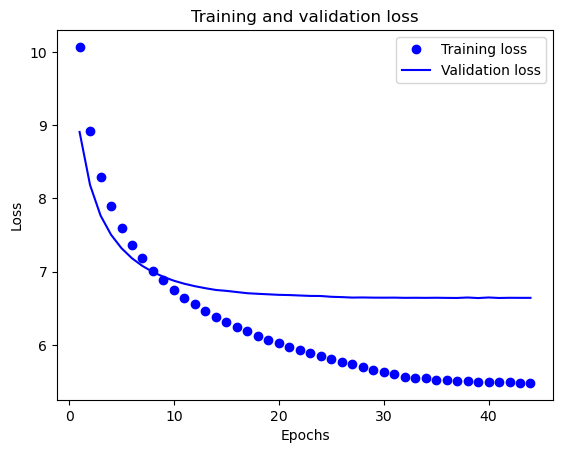

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = train_state['train_acc']
val_acc = train_state['val_acc']
loss = train_state['train_loss']
val_loss = train_state['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

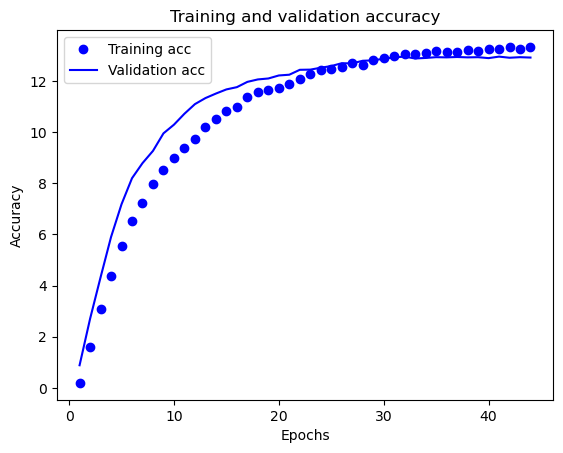

In [25]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [26]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename'], weights_only=False))
classifier = classifier.to(args.device)
loss_func = nn.CrossEntropyLoss()

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    with torch.no_grad():  # Disable gradient computation
         y_pred =  classifier(x_in=batch_dict['x_data'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc


In [27]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 7.879440082694001;
Test Accuracy: 12.094634433962266


### Trained Embeddings

In [29]:
def pretty_print(results):
    """
    Pretty print embedding results.
    """
    for item in results:
        print ("...[%.2f] - %s"%(item[1], item[0]))  # print distance, word

def get_closest(target_word, word_to_idx, embeddings, n=5):
    """
    Get the n closest
    words to your word.
    """

    # Calculate distances to all other words
    
    word_embedding = embeddings[word_to_idx[target_word.lower()]]
    distances = []
    for word, index in word_to_idx.items():
        if word == "<MASK>" or word == target_word:
            continue
        distances.append((word, torch.dist(word_embedding, embeddings[index])))  # measure Euclidean distance
    
    results = sorted(distances, key=lambda x: x[1])[0:n]
    return results


In [30]:
word = input('Enter a word: ')
embeddings = classifier.embedding.weight.data  # learned word embeddings
word_to_idx = vectorizer.cbow_vocab._token_to_idx
pretty_print(get_closest(word, word_to_idx, embeddings, n=5))  # enter "monster"

Enter a word:  monster


...[7.32] - permit
...[7.54] - cares
...[7.69] - saw
...[7.72] - griefs
...[7.77] - truly


In [31]:
embeddings.shape

torch.Size([6138, 50])

In [32]:
target_words = ['frankenstein', 'monster', 'science', 'sickness', 'lonely', 'happy']

embeddings = classifier.embedding.weight.data
word_to_idx = vectorizer.cbow_vocab._token_to_idx

for target_word in target_words: 
    print(f"======={target_word}=======")
    if target_word not in word_to_idx:
        print("Not in vocabulary")
        continue
    pretty_print(get_closest(target_word, word_to_idx, embeddings, n=5))

=======frankenstein=======
...[6.83] - dead
...[6.91] - discrimination
...[6.91] - slight
...[6.96] - wandering
...[6.98] - oppressive
=======monster=======
...[7.32] - permit
...[7.54] - cares
...[7.69] - saw
...[7.72] - griefs
...[7.77] - truly
=======science=======
...[6.54] - picture
...[6.92] - mutual
...[6.95] - mist
...[6.97] - impression
...[7.00] - swelling
=======sickness=======
...[5.58] - solicited
...[6.25] - while
...[6.54] - foundations
...[6.62] - probabilities
...[6.63] - awoke
=======lonely=======
...[6.59] - excessive
...[6.79] - unveiled
...[6.90] - moonlight
...[7.07] - ought
...[7.11] - bed
=======happy=======
...[6.16] - wand
...[6.26] - bottom
...[6.35] - injury
...[6.42] - chivalry
...[6.44] - penetrated


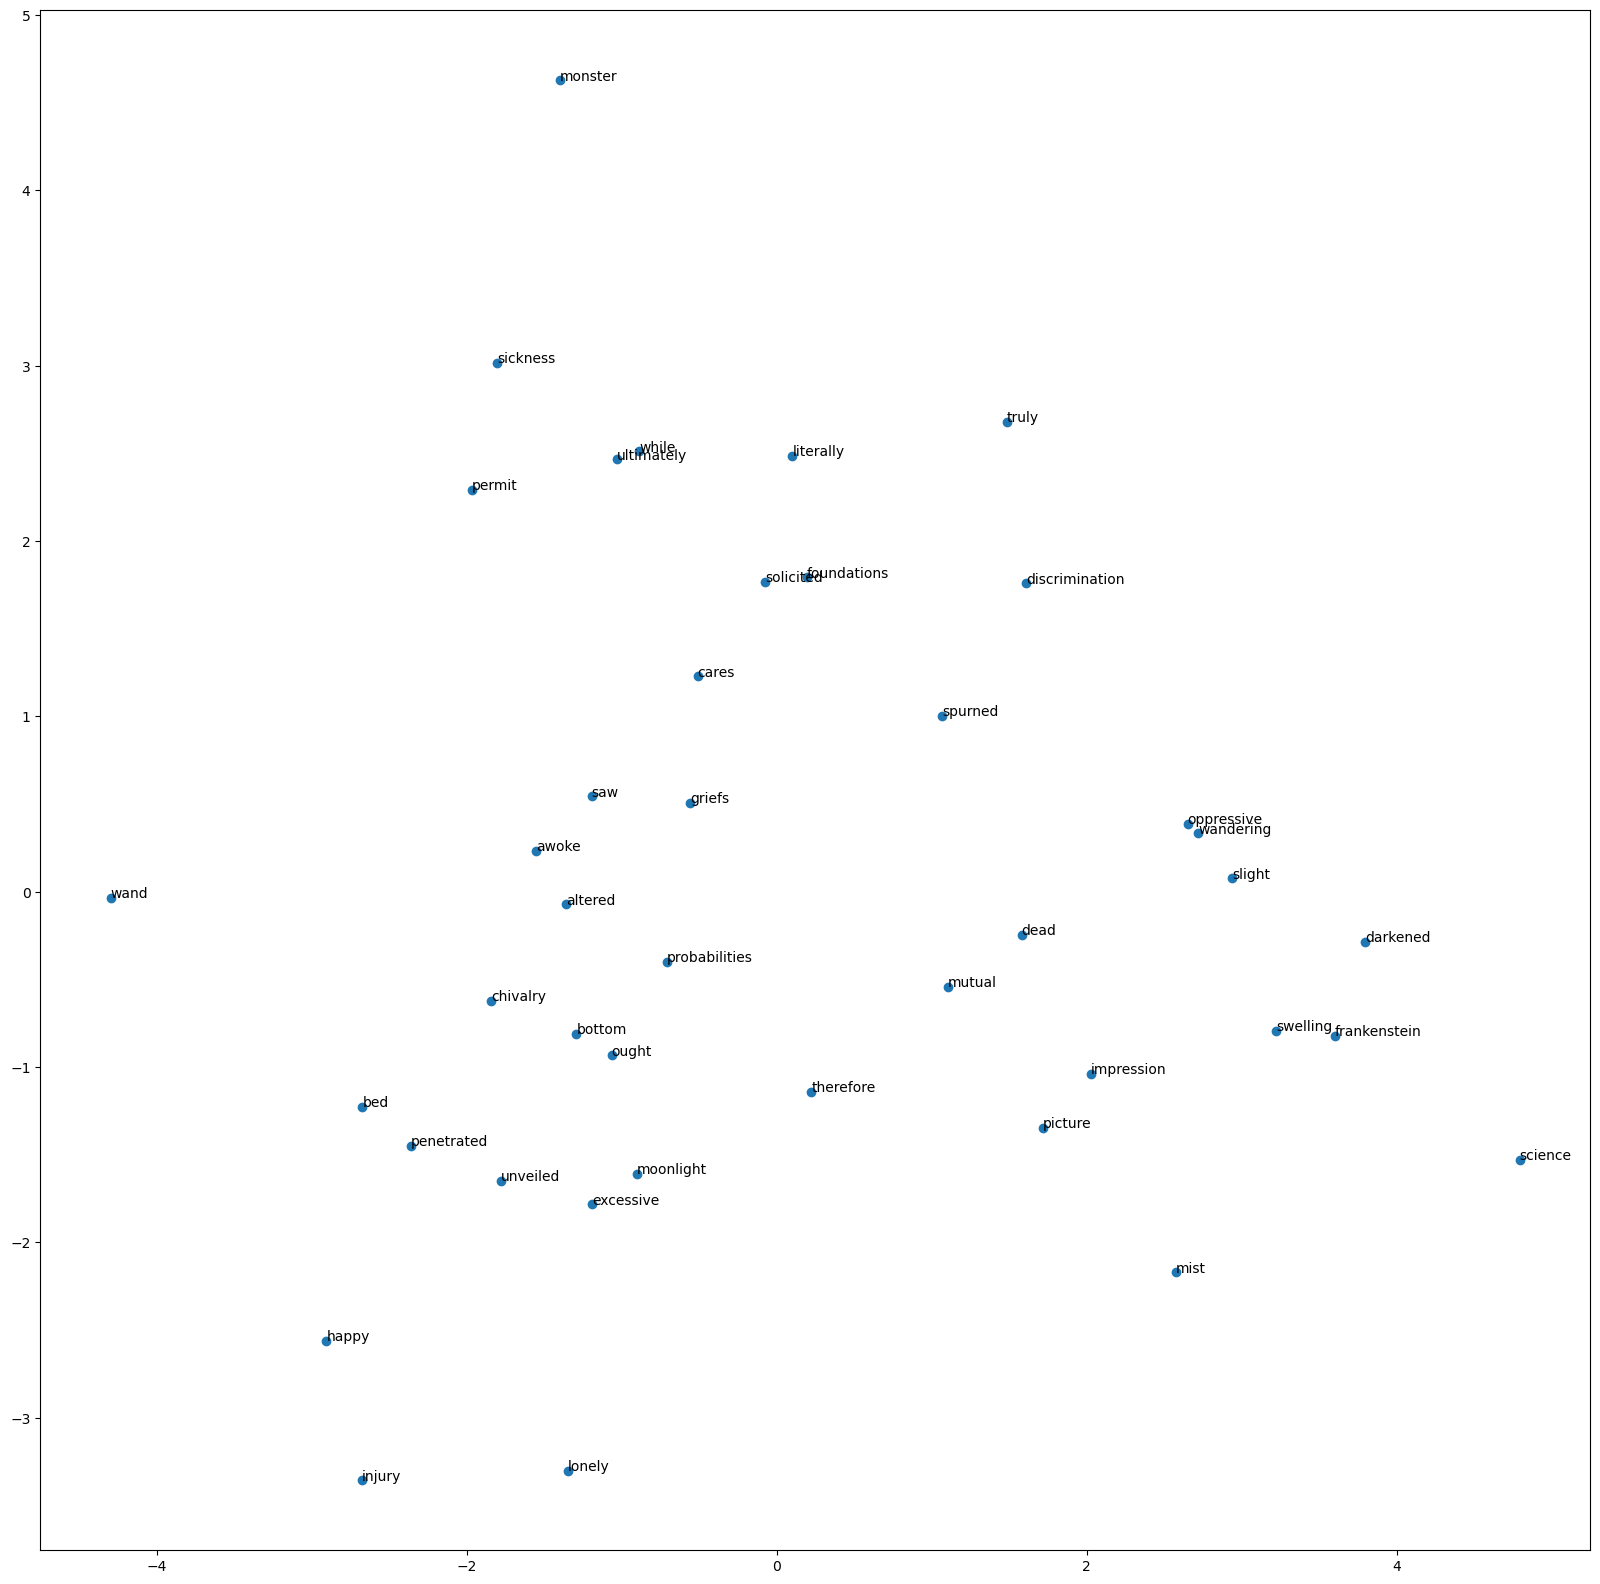

In [33]:
# fit a 2d PCA model to the vectors
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot

pyplot.rcParams["figure.figsize"] = (20,20)
words = [ 'frankenstein', 'monster', 'science', 'sickness', 'lonely', 'happy',
         'dead', 'discrimination', 'slight', 'oppressive', 'wandering', 'spurned',
         'permit', 'cares', 'griefs', 'saw', 'truly', 'ultimately',
         'picture', 'mutual', 'mist', 'impression', 'swelling', 'darkened',
         'solicited', 'while', 'foundations', 'awoke', 'probabilities', 'literally',
         'excessive', 'unveiled', 'moonlight', 'ought', 'bed', 'therefore',
         'wand', 'bottom', 'injury', 'chivalry', 'penetrated', 'altered']
X = np.array([embeddings[word_to_idx[w.lower()]].numpy() for w in words]) # retrieve all of the vectors in words from a trained model
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1])) # annotate the points on the graph with the words themselves. 
pyplot.show()

### Excercise:

The baseline Model: Test loss: 7.895888688429347; Test Accuracy: 12.205188679245282
1. Change the value of embedding_size=50 to 100 or other values 